# Case Study 3

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.

#### Requirements

  * compare at least 2 feature selection methods (groups of 5-6: at least 4)
    - filtering methods (at least one scoring function)
    - wrapper methods (at least one, e.g., forward feature selection or backward feature elimination)
    - embedding methods  (at least one, e.g., L1 regularisation)
 * combine each method with at least 2 classifiers
   (justify your choice of classifiers in the report)
    - SVM
    - KNN
    - ...
  * perform Leave-one-group-out cross-validation, where all 10 samples from each subject are in one group (18 groups in total)
  * use cross-validation to optimise hyper-parameter values
  * as a baseline for comparison, evaluate each of your classifiers trained on the full set of features (trained without feature selection)




In [1]:
import csv
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',')
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

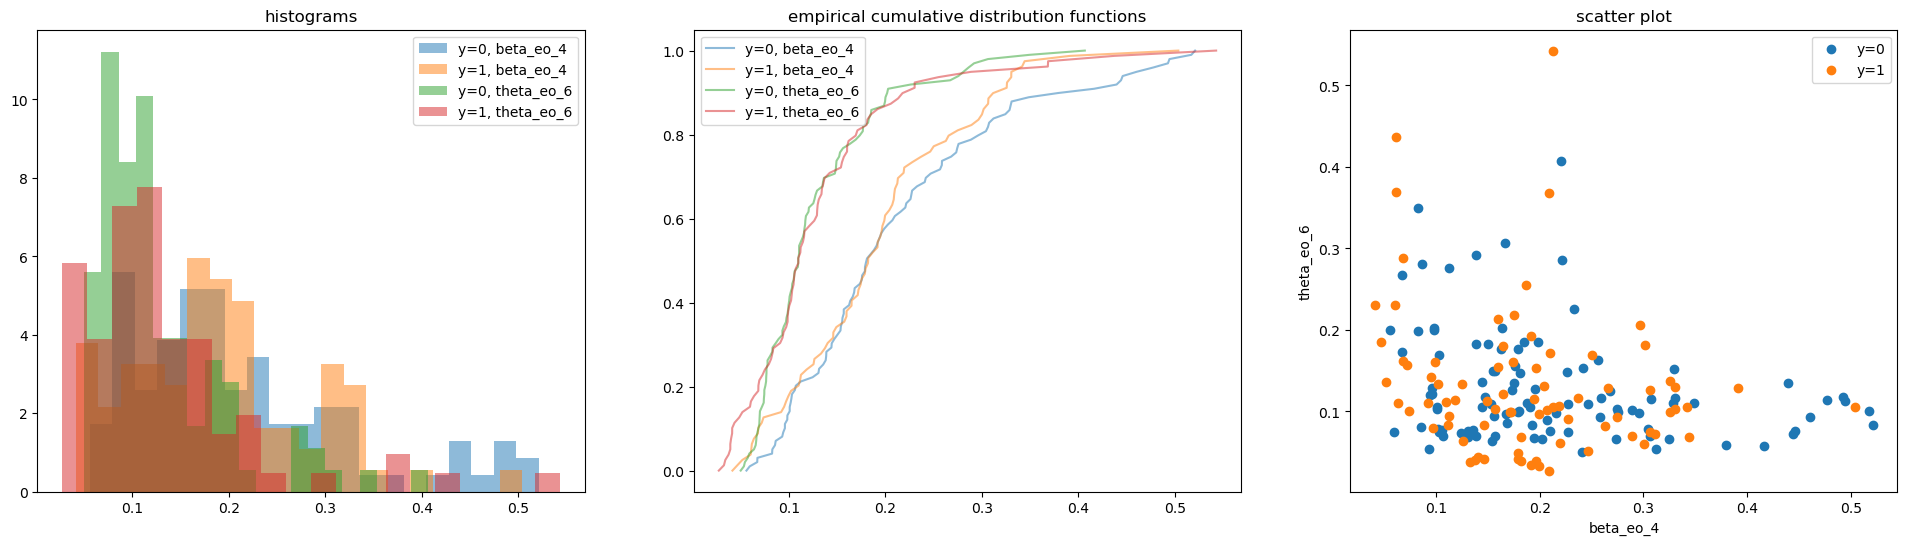

In [3]:
# plotting data in 2D with axes sampled
# a) at random
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV, SelectFromModel
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score
from mlxtend.feature_selection import SequentialFeatureSelector



# Load data
data = pd.read_csv('data.csv', header=None)
feature_names = pd.read_csv('feature_names.csv', header=None)
labels = pd.read_csv('labels.csv', header=None)

In [18]:
# Extract features and labels
X = data.values
y = labels.values.ravel()

# Create groups for LeaveOneGroupOut cross-validation
subjects = np.repeat(np.arange(18), 10)

# Classifiers
svm_clf = SVC(kernel='linear', class_weight='balanced')  # Use linear kernel
knn_clf = KNeighborsClassifier()
tree_clf = DecisionTreeClassifier()

# Feature Selection Methods
filter_methods = [
    ('chi2', make_pipeline(MinMaxScaler(), SelectKBest(chi2, k=5))), 
    ('rfe_svm', make_pipeline(MinMaxScaler(), RFE(svm_clf, n_features_to_select=5))), 
    ('rfe_knn', make_pipeline(MinMaxScaler(), RFE(knn_clf, n_features_to_select=5))), 
    ('rfe_tree', make_pipeline(MinMaxScaler(), RFE(tree_clf, n_features_to_select=5))), 
    ('rfecv_svm', make_pipeline(MinMaxScaler(), RFECV(estimator=svm_clf, step=1, scoring='accuracy'))), 
    ('rfecv_knn', make_pipeline(MinMaxScaler(), RFECV(estimator=knn_clf, step=1, scoring='accuracy'))), 
    ('rfecv_tree', make_pipeline(MinMaxScaler(), RFECV(estimator=tree_clf, step=1, scoring='accuracy'))),
    ('tree_svm', make_pipeline(MinMaxScaler(), SelectFromModel(svm_clf))),
    ('tree_knn', make_pipeline(MinMaxScaler(), SelectFromModel(knn_clf))),
    ('tree_tree', make_pipeline(MinMaxScaler(), SelectFromModel(tree_clf))),
    ('sfs_svm', make_pipeline(MinMaxScaler(), SequentialFeatureSelector(svm_clf, scoring='accuracy', k_features='best', forward=True))),
    ('sfs_knn', make_pipeline(MinMaxScaler(), SequentialFeatureSelector(knn_clf, scoring='accuracy', k_features='best', forward=True))),
    ('sfs_tree', make_pipeline(MinMaxScaler(), SequentialFeatureSelector(tree_clf, scoring='accuracy', k_features='best', forward=True)))
]

# Classifiers
classifiers = [
    ('rf', RandomForestClassifier()),
    ('svm', svm_clf),
    ('knn', knn_clf)
]

# Results
results = []

In [19]:
# Iterate over feature selection methods and classifiers
for feature_name, feature_selector in filter_methods:
    for clf_name, clf in classifiers:
        # Skip RFE methods for KNN
        if 'rfe' in feature_name and 'knn' in clf_name:
            continue

        # Create a pipeline with feature selection and classifier
        model = make_pipeline(feature_selector, clf)

        # Cross-validation
        loo = LeaveOneGroupOut()
        accuracies, recalls, precisions = [], [], []

        for train_index, test_index in loo.split(X, y, groups=subjects):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Fit the model
            model.fit(X_train, y_train)

            # Predictions
            y_pred = model.predict(X_test)

            # Evaluation metrics
            accuracies.append(accuracy_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred, zero_division=0))  # Handle zero division warning
            precisions.append(precision_score(y_test, y_pred, zero_division=0))  # Handle zero division warning

        # Save results
        results.append({
            'Feature_Selection': feature_name,
            'Classifier': clf_name,
            'Accuracy': np.mean(accuracies),
            'Recall': np.mean(recalls),
            'Precision': np.mean(precisions)
        })

# Display results
results_df = pd.DataFrame(results)
print(results_df)

ValueError: when `importance_getter=='auto'`, the underlying estimator KNeighborsClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [13]:
# Iterate over feature selection methods and classifiers
for feature_name, feature_selector in filter_methods:
    for clf_name, clf in classifiers:
        # Skip RFE methods for KNN
        if 'rfe' in feature_name and 'knn' in clf_name:
            continue

        # Create a pipeline with feature selection and classifier
        model = make_pipeline(feature_selector, clf)

        # Cross-validation
        loo = LeaveOneGroupOut()
        accuracies, recalls, precisions = [], [], []

        for train_index, test_index in loo.split(X, y, groups=subjects):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Fit the model
            model.fit(X_train, y_train)

            # Predictions
            y_pred = model.predict(X_test)

            # Evaluation metrics
            accuracies.append(accuracy_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred, zero_division=0))  # Handle zero division warning
            precisions.append(precision_score(y_test, y_pred, zero_division=0))  # Handle zero division warning

        # Save results
        results.append({
            'Feature_Selection': feature_name,
            'Classifier': clf_name,
            'Accuracy': np.mean(accuracies),
            'Recall': np.mean(recalls),
            'Precision': np.mean(precisions)
        })

# Display results
results_df = pd.DataFrame(results)
print(results_df)

  Feature_Selection Classifier  Accuracy    Recall  Precision
0              chi2        svm  0.727778  0.277778   0.444444
1              chi2        knn  0.605556  0.227778   0.444444
2           rfe_svm        svm  0.783333  0.333333   0.444444
3         rfecv_svm        svm  0.916667  0.411111   0.444444
4          tree_knn        svm  0.772222  0.283333   0.444444
5          tree_knn        knn  0.838889  0.333333   0.444444


In [ ]:
# Wrapper and Embedding Methods
wrapper_embedding_methods = [
    ('sfs_svm', make_pipeline(MinMaxScaler(), SequentialFeatureSelector(svm_clf, scoring='accuracy', k_features='best', forward=True))),
    ('rfecv_svm', make_pipeline(MinMaxScaler(), RFECV(estimator=svm_clf, step=1, scoring='accuracy'))), 
    ('tree_svm', make_pipeline(MinMaxScaler(), SelectFromModel(svm_clf))),
    ('sfs_knn', make_pipeline(MinMaxScaler(), SequentialFeatureSelector(knn_clf, scoring='accuracy', k_features='best', forward=True))),
    ('rfecv_knn', make_pipeline(MinMaxScaler(), RFECV(estimator=knn_clf, step=1, scoring='accuracy'))),
    ('tree_knn', make_pipeline(MinMaxScaler(), SelectFromModel(tree_clf))),
    
]

In [16]:
# Iterate over feature selection methods and classifiers
for feature_name, feature_selector in filter_methods + wrapper_embedding_methods:
    for clf_name, clf in classifiers:
        # Create a pipeline with feature selection and classifier
        model = make_pipeline(feature_selector, clf)

        # Cross-validation
        loo = LeaveOneGroupOut()
        accuracies, recalls, precisions = [], [], []

        for train_index, test_index in loo.split(X, y, groups=subjects):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Fit the model
            model.fit(X_train, y_train)

            # Predictions
            y_pred = model.predict(X_test)

            # Evaluation metrics
            accuracies.append(accuracy_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred, zero_division=0))  # Handle zero division warning
            precisions.append(precision_score(y_test, y_pred, zero_division=0))  # Handle zero division warning

        # Save results
        results.append({
            'Feature_Selection': feature_name,
            'Classifier': clf_name,
            'Accuracy': np.mean(accuracies),
            'Recall': np.mean(recalls),
            'Precision': np.mean(precisions)
        })

# Display results
results_df = pd.DataFrame(results)
print(results_df)

ValueError: when `importance_getter=='auto'`, the underlying estimator KNeighborsClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.